## imports, etc.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import torchvision
from tqdm.notebook import tqdm
import os
from sklearn.semi_supervised import LabelPropagation
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

In [2]:
np.random.seed(0)

In [2]:
X_train = torch.load("data/FashionMNIST_train_latent.pt")
X_test = torch.load("data/FashionMNIST_test_latent.pt")
y_train = torch.load("data/FashionMNIST_train_labels.pt")
y_test = torch.load("data/FashionMNIST_test_labels.pt")

In [3]:
os.chdir("../fashion_ml")

In [4]:
from fashion_vae import FashionVAE
from data_loader import EZ_Dataloader
from experiment import FashionML

In [5]:
import warnings
warnings.filterwarnings("ignore")

## limit data labels

In [6]:
X = torch.cat((X_train, X_test), 0)
y = torch.cat((y_train, y_test), 0)

discard all but 200 random labels (we can increase the number but I feel like 1000+ doesn't really count as semi-supervised anymore)

In [8]:
n_labeled = 200

In [9]:
ind = np.random.randint(len(X), size=(n_labeled))
y_lim = np.repeat(-1, len(y))
y_lim[ind] = y[ind]

## semi-supervised clustering

search for optimal k: 2 is optimal, anything over 3 predicts everything as the first class. overall clustering does not work well at all.

In [10]:
def test_knn(n):
    lpm = LabelPropagation(kernel='knn',n_neighbors=n,n_jobs=-1,max_iter=5000)
    lpm.fit(X, y_lim)
    print(lpm.score(X, y))
    y_pred = lpm.predict(X)
    print(np.unique(y_pred))
    return lpm

In [11]:
test_knn(2)

KeyboardInterrupt: 

In [ ]:
test_knn(3)

In [ ]:
test_knn(7)

In [ ]:
test_knn(12)

final clusters:

In [12]:
lpm = LabelPropagation(kernel='knn',n_neighbors=2,n_jobs=-1,max_iter=5000)
lpm.fit(X, y_lim)
y_pred = lpm.predict(X)

KeyboardInterrupt: 

## mlp models

pull out train vs. test:

In [ ]:
X_train = X[y_lim != -1]
X_test = X[y_lim == -1]
y_train = y[y_lim != -1]
y_test = y[y_lim == -1]

test a few networks:

In [35]:
clf = MLPClassifier(hidden_layer_sizes=(20,5), tol=1e-5)
clf.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(20, 5), tol=1e-05)

In [36]:
clf.score(X_test, y_test)

0.3267908309455587

In [43]:
clf = MLPClassifier(hidden_layer_sizes=(100,20,5), tol=1e-4)
clf.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(100, 20, 5))

In [44]:
clf.score(X_test, y_test)

0.4045845272206304

In [59]:
clf = MLPClassifier(hidden_layer_sizes=(200,100,25,5), tol=1e-5)
clf.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(200, 100, 25, 5), tol=1e-05)

In [60]:
clf.score(X_test, y_test)

0.5203581661891118

## test different numbers of labeled points

In [7]:
ns = [30, 50, 75, 100, 150, 200, 500, 1000, 1500, 2000]

In [19]:
def rep(n, X_dat, y_dat,c):
    ind = np.random.randint(len(y_dat), size=(n))
    y_lim = np.repeat(-1, len(y_dat))
    y_lim[ind] = y[ind]
    X_train = X_dat[y_lim != -1]
    X_test = X_dat[y_lim == -1]
    y_train = y_dat[y_lim != -1]
    y_test = y_dat[y_lim == -1]
    if c:
        clf = MLPClassifier(hidden_layer_sizes=(1000,200,100,100,25,5), tol=1e-6)
    else:
        clf = MLPClassifier(hidden_layer_sizes=(200,100,25,5), tol=1e-5)
    clf.fit(X_train, y_train)
    return clf.score(X_test, y_test)

In [20]:
def test_mlp(n, X_dat, y_dat, complex_model=False):
    max_score = rep(n, X_dat, y_dat, complex_model)
    for i in range(6):
        score = rep(n, X_dat, y_dat, complex_model)
        if score > max_score:
            max_score = score
    return max_score

In [21]:
res = []

In [22]:
for n in ns:
    res.append(test_mlp(n, X, y))

## compare to full images

In [23]:
from sklearn.datasets import fetch_openml

In [24]:
data = fetch_openml('Fashion-MNIST')

In [25]:
X2 = data['data']

In [26]:
y2 = data['target']

In [27]:
res2 = []

In [28]:
for n in ns:
    res2.append(test_mlp(n, X2, y2,True))

## make a plot :)

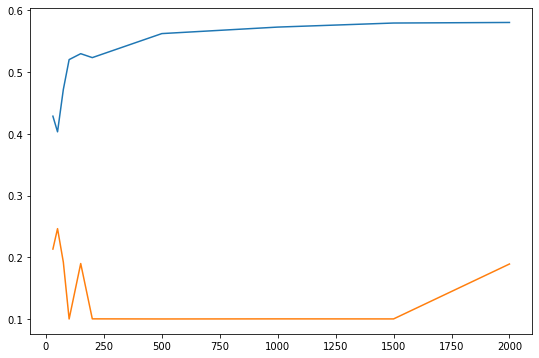

In [29]:
plt.figure(figsize=(9,6))
plt.plot(ns, res)
plt.plot(ns, res2)
plt.show()

our latent representations are in blue, original images in orange